# TITANIC

In [1]:
# Import of libraries
import pandas as pd
import numpy as np
import matplotlib as mtl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sc
import sklearn
import warnings
warnings.filterwarnings('ignore') 
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
#Import of data
prediction = pd.read_csv("test.csv", sep = ",")
train = pd.read_csv("train.csv", sep = ",")
data = train.append(prediction) 
prediction_indexes = prediction['PassengerId']
del data['PassengerId']
data.reset_index(inplace = True)
del data['index']

# Observation

In [3]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


# Balance of data

An important thing is to understand target value distribution. It may define your choice of algorithm. 
If some class prevails then you data is imbalanced, what can cause problems in learning. 
There is no clear definition, when data is considered to be imbalanced. 
With one class comprising approximately over 80% of distribution it may be imbalanced. 
In our case data is quite balanced. 

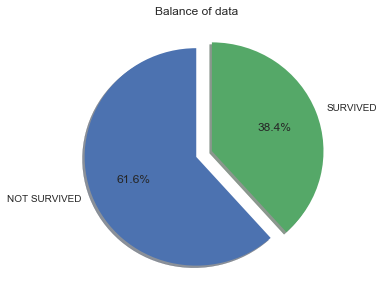

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
pd.value_counts(train["Survived"])
plt.pie([pd.value_counts(train["Survived"])[0], pd.value_counts(train["Survived"])[1]], 
        labels=["NOT SURVIVED", "SURVIVED"], 
        startangle=90, 
        shadow=True, 
        explode=(0, 0.15),
        autopct='%1.1f%%')
plt.title('Balance of data')

## 1.1. Sanity check

In [5]:
print("Sanity check for Age: ")
print(((data['Age']>100) | (data['Age']<0)).any())
print ("Sanity check for SibSp: ")
print((data['SibSp']<0).any())
print ("Sanity check for Sex: ")
print(((data['Sex'] != 'male') & (data['Sex']!='female')).any())  

Sanity check for Age: 
False
Sanity check for SibSp: 
False
Sanity check for Sex: 
False


## 1.2 Duplicates

In [6]:
data.duplicated().any()

False

## 1.3 Leaks

I believe, that one of the leaks could be 'MissingCabin'. 
Probably it was harder to identify cabins of those who didn't survive. Let's check this assumption. 

In [7]:
data['MissingCabin'] = 0
data.loc[data['Cabin'].isnull() == True, 'MissingCabin'] = 1

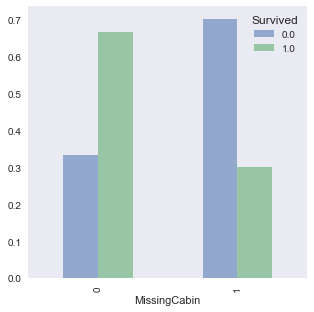

In [8]:
#Relative values
plt.rcParams['figure.figsize'] = (5, 5)
cross = pd.crosstab(data['MissingCabin'], data["Survived"])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=False,  grid=False, alpha=0.55)

Indeed, we see much lower survival rate among those who have missing values. 

## 1.4 Missing values

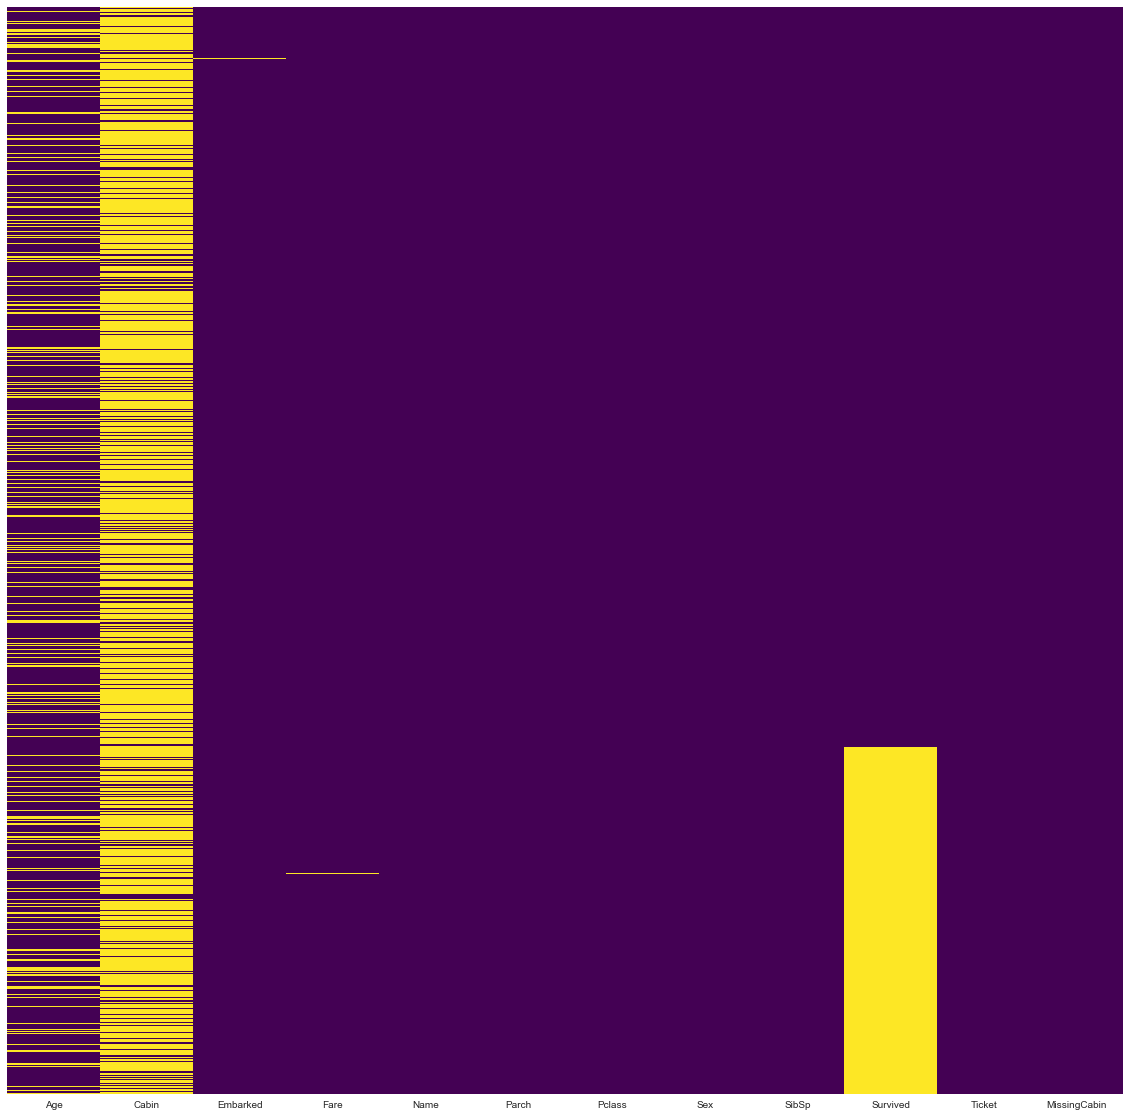

In [9]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

## 1.5 Feature analysis

In [10]:
# 1.5.2 Correlation
data.corr()

,Age,Fare,Parch,Pclass,SibSp,Survived,MissingCabin
Age,1.000000,0.178740,-0.150917,-0.408106,-0.243699,-0.077221,-0.289740
Fare,0.178740,1.000000,0.221539,-0.558629,0.160238,0.257307,-0.507253
Parch,-0.150917,0.221539,1.000000,0.018322,0.373587,0.081629,-0.036806
Pclass,-0.408106,-0.558629,0.018322,1.000000,0.060832,-0.338481,0.713857
SibSp,-0.243699,0.160238,0.373587,0.060832,1.000000,-0.035322,0.009064
Survived,-0.077221,0.257307,0.081629,-0.338481,-0.035322,1.000000,-0.316912
MissingCabin,-0.289740,-0.507253,-0.036806,0.713857,0.009064,-0.316912,1.000000


## 2. Preprocessing

### 2.1 Missing values imputation

In [11]:
# Embarked 
data.Embarked.fillna('S', inplace=True)

In [12]:
# Age
# Imputing missing values in 'Age'
def age_imputer(dataset):
    for i in range(len(dataset.Age)):
        if dataset.Age.isnull().iloc[i]: 
            dataset.Age.iloc[i] = dataset[(dataset["Pclass"] == dataset["Pclass"].iloc[i]) 
                                    & (dataset["Sex"] == dataset["Sex"].iloc[i])]["Age"].median()

In [13]:
age_imputer(data[:891])
age_imputer(data[891:])

In [14]:
# Fare
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

In [15]:
# Cabin
# Cabin has too many missing values and information containing in Pclass. 
del data['Cabin']

In [16]:
data[data.columns.difference(['Survived'])].isnull().any()

Age             False
Embarked        False
Fare            False
MissingCabin    False
Name            False
Parch           False
Pclass          False
Sex             False
SibSp           False
Ticket          False
dtype: bool

### 2.2 Feature engineering

In [17]:
data['Group'] = np.nan
data.loc[(data['Age'] <= 5) & (data['Pclass'] == 1), 'Group'] = "Inf1"
data.loc[(data['Age'] <= 5) & (data['Pclass'] == 2), 'Group'] = "Inf2"
data.loc[(data['Age'] <= 5) & (data['Pclass'] == 3), 'Group'] = "Inf3"

data.loc[(data['Age'] > 5) & (data['Age'] <= 18) & (data['Pclass'] == 1) , 'Group'] = "Child1"
data.loc[(data['Age'] > 5) & (data['Age'] <= 18) & (data['Pclass'] == 2) , 'Group'] = "Child2"
data.loc[(data['Age'] > 5) & (data['Age'] <= 18) & (data['Pclass'] == 3) , 'Group'] = "Child3"

data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 1) & (data['Sex'] == 'male'), 'Group'] = "Man1"
data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 2) & (data['Sex'] == 'male'), 'Group'] = "Man2"
data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 3) & (data['Sex'] == 'male'), 'Group'] = "Man3"

data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 1) & (data['Sex'] == 'female'), 'Group'] = "Woman1"
data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 2) & (data['Sex'] == 'female'), 'Group'] = "Woman2"
data.loc[(data['Age'] > 18) & (data['Age'] <= 50) & (data['Pclass'] == 3) & (data['Sex'] == 'female'), 'Group'] = "Woman3"

data.loc[(data['Age'] > 50)  & (data['Pclass'] == 1) & (data['Sex'] == 'female'), 'Group'] = "SeniorF1"
data.loc[(data['Age'] > 50)  & (data['Pclass'] == 2) & (data['Sex'] == 'female'), 'Group'] = "SeniorF2"
data.loc[(data['Age'] > 50)  & (data['Pclass'] == 3) & (data['Sex'] == 'female'), 'Group'] = "SeniorF3"

data.loc[(data['Age'] > 50)  & (data['Pclass'] == 1) & (data['Sex'] == 'male'), 'Group'] = "SeniorM1"
data.loc[(data['Age'] > 50)  & (data['Pclass'] == 2) & (data['Sex'] == 'male'), 'Group'] = "SeniorM2"
data.loc[(data['Age'] > 50)  & (data['Pclass'] == 3) & (data['Sex'] == 'male'), 'Group'] = "SeniorM3"



Conclusions: 
1. By far the biggest group is men in the third class. Thus, it's very important to focus on them, as their contribution to 
accuracy is vital. 
2. Child1, Woman1 and Woman2 have great chances to survive. Inf2 as well. Inf1 seem to be a very small group to draw conclusions. Logically, they should also have good chances. 
3. It will be hard to predict Woman3, Man1, Senior1, because their chances are very close to 50:50. 
4. SeniorM1,SeniorM2 SeniorM3, Man2 and Man3 have the lowest chances. 
5. I didn't expect many survivors among female seniors. Though we have too few observations for those in classes 2 and 3. 

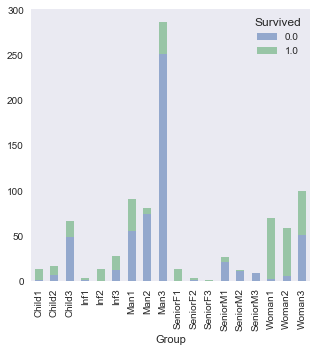

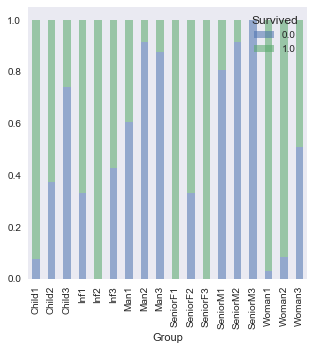

In [19]:
plt.rcParams['figure.figsize'] = (5, 5)
cross_abs = pd.crosstab(data['Group'], data["Survived"])
cross_rel = cross_abs.div(cross_abs.sum(1).astype(float), axis=0)
cross_abs.plot(kind='bar', stacked=True,  grid=False, alpha=0.55)
cross_rel.plot(kind='bar', stacked=True,  grid=False, alpha=0.55)

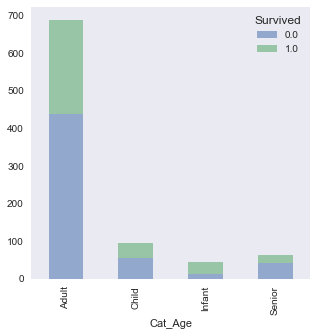

In [94]:
plt.rcParams['figure.figsize'] = (5, 5)
cross = pd.crosstab(data['Cat_Age'], data["Survived"])
#cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=True,  grid=False, alpha=0.55)

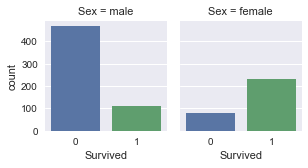

In [93]:
sns.factorplot("Survived", col='Sex', col_wrap=4,
                        data=train,
                        kind="count", size=2.5, aspect=.8);

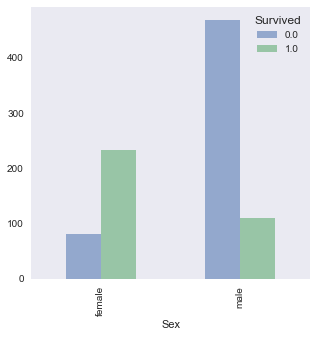

In [92]:
plt.rcParams['figure.figsize'] = (5, 5)
cross = pd.crosstab(data['Sex'], data["Survived"])
#cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=False,  grid=False, alpha=0.55)

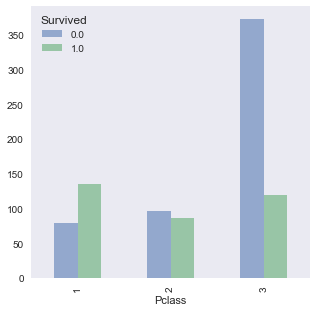

In [90]:
plt.rcParams['figure.figsize'] = (5, 5)
cross = pd.crosstab(data['Pclass'], data["Survived"])
#cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=False,  grid=False, alpha=0.55)

In [20]:
# Fare 
data['FareBin'] = pd.qcut(data['Fare'], 5)
del data['Fare']

In [21]:
# Name
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [22]:
pd.value_counts(data.Title)

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Sir           1
Mme           1
Lady          1
Capt          1
Dona          1
Countess      1
Jonkheer      1
Name: Title, dtype: int64

In [23]:
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                            'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')

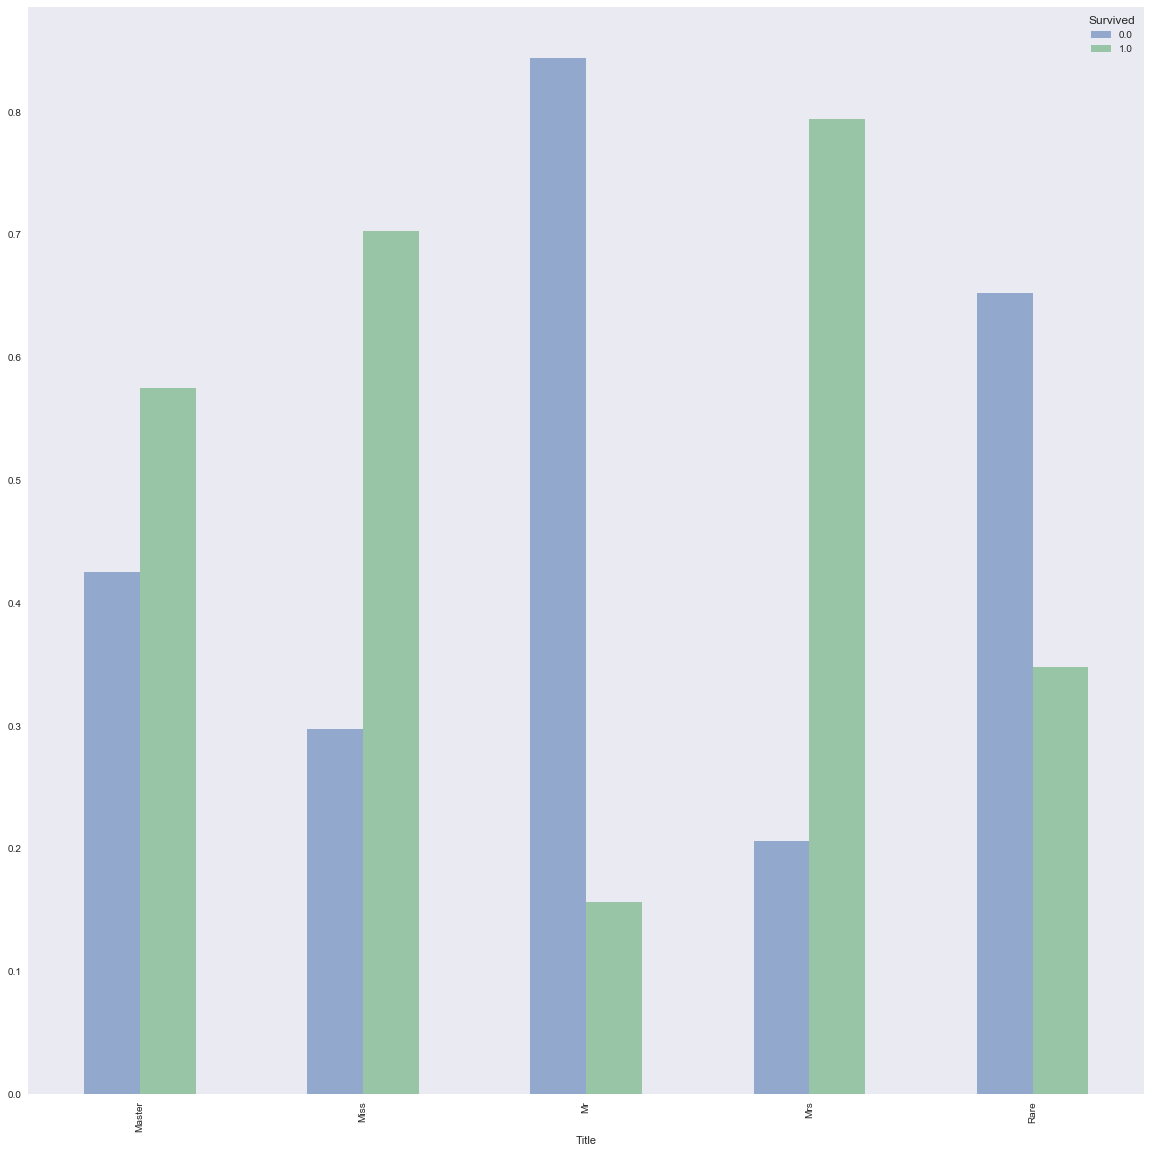

In [24]:
#Relative values
cross = pd.crosstab(data['Title'], data['Survived'])
cross = cross.div(cross.sum(1).astype(float), axis=0)
cross.plot(kind='bar', stacked=False,  grid=False, alpha=0.55)
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [25]:
del data['Title']

In [26]:
del data['Name']

In [27]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
del data['SibSp']
del data['Parch']

In [28]:
del data['Ticket']

In [29]:
data.head()

,Embarked,Pclass,Sex,Survived,MissingCabin,Cat_Age,FareBin,FamilySize
0,S,3,male,0.0,1,Adult,"(-0.001, 7.854]",2
1,C,1,female,1.0,0,Adult,"(41.579, 512.329]",2
2,S,3,female,1.0,1,Adult,"(7.854, 10.5]",1
3,S,1,female,1.0,0,Adult,"(41.579, 512.329]",2
4,S,3,male,0.0,1,Adult,"(7.854, 10.5]",1


In [30]:
mapper_1 = {'male': 0, 'female': 1}
data["Sex"] = data["Sex"].map(mapper_1)

mapper_2 = {'Infant': 0, 'Child': 1, 'Adult':2, 'Senior': 3}
data["Cat_Age"] = data["Cat_Age"].map(mapper_2)

mapper_3 = {'S': 0, 'Q': 1, 'C': 2}
data["Embarked"] = data["Embarked"].map(mapper_3)

In [31]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
data['FareBin'] = label.fit_transform(data['FareBin'])

In [32]:
data.head()

,Embarked,Pclass,Sex,Survived,MissingCabin,Cat_Age,FareBin,FamilySize
0,0,3,0,0.0,1,2,0,2
1,2,1,1,1.0,0,2,4,2
2,0,3,1,1.0,1,2,1,1
3,0,1,1,1.0,0,2,4,2
4,0,3,0,0.0,1,2,1,1


In [47]:
data['Cl*Sex'] = data['Sex'] * data['Pclass'] 
data['Cl*Age'] = data['Cat_Age'] * data['Pclass'] 

## 2.3 Feature selection

In [36]:
data = pd.get_dummies(data, columns = ["Embarked"])

In [49]:
X = data[:891][data.columns.difference(['Survived'])]
Y = data[:891]['Survived']

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier() 
model.fit(X, Y)
for i, z in zip(X.columns, model.feature_importances_):
    print(i, z)   

Cat_Age 0.0531980358901
Cl*Age 0.0778130633535
Cl*Sex 0.227836184691
FamilySize 0.112914765626
FareBin 0.110805580838
MissingCabin 0.0608561100273
Pclass 0.128367606231
Sex 0.228208653343


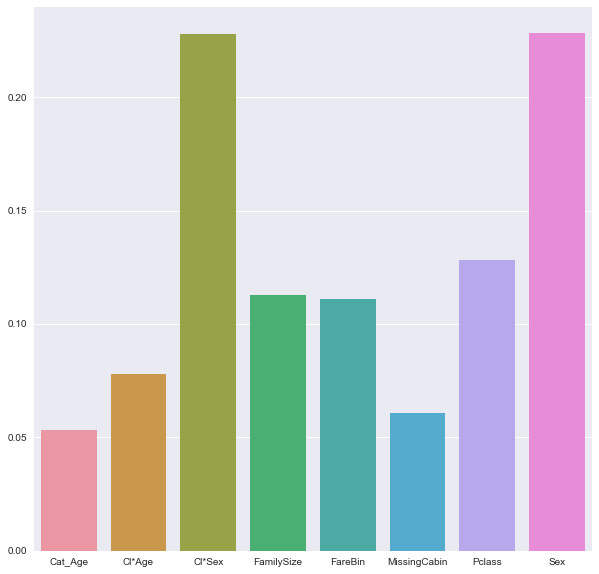

In [50]:
sns.barplot(x=X.columns, y=model.feature_importances_)
plt.show()

In [39]:
del data['Embarked_0']
del data['Embarked_1']
del data['Embarked_2']

In [56]:
del data['Cat_Age']
del data['MissingCabin']
del data['Cl*Age']

In [40]:
data.head()

,Pclass,Sex,Survived,MissingCabin,Cat_Age,FareBin,FamilySize
0,3,0,0.0,1,2,0,2
1,1,1,1.0,0,2,4,2
2,3,1,1.0,1,2,1,1
3,1,1,1.0,0,2,4,2
4,3,0,0.0,1,2,1,1


In [57]:
X = data[:891][data.columns.difference(['Survived'])]
Y = data[:891]['Survived']
X_pred = data[891:][data.columns.difference(['Survived'])]

## 3. Model building

### 3.1 Model training
#### 3.1.1 Parameter setting via GridSearch

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [58]:
logreg = LogisticRegression()
svc_lin = SVC(kernel='linear')
svc_rbf = SVC(kernel='rbf')
knn = KNeighborsClassifier(algorithm='auto', leaf_size=16, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
decision_tree = DecisionTreeClassifier(max_depth=6 )
random_forest = RandomForestClassifier(max_depth=6, n_estimators=10)
extra_trees = ExtraTreesClassifier(max_depth=6,n_estimators=10)
gbc = GradientBoostingClassifier()
ada = AdaBoostClassifier()

models = [logreg, svc_lin, svc_rbf, knn, 
              decision_tree, random_forest, extra_trees, gbc, ada]

In [59]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)

In [60]:
np.set_printoptions(suppress=True)

number_models = len(models)
folds = 5

Chart_1 = np.zeros((len(data[:891]),number_models))
Chart_2 = np.zeros((len(data[891:]), folds))
Chart_3 = np.zeros((len(data[891:]), number_models))

#X_pred = X.iloc[prediction_indexes]#[data.columns.difference(['Survived'])]
#X_pred.drop(X_pred.iloc[:, col_to_drop], axis=1, inplace = True)

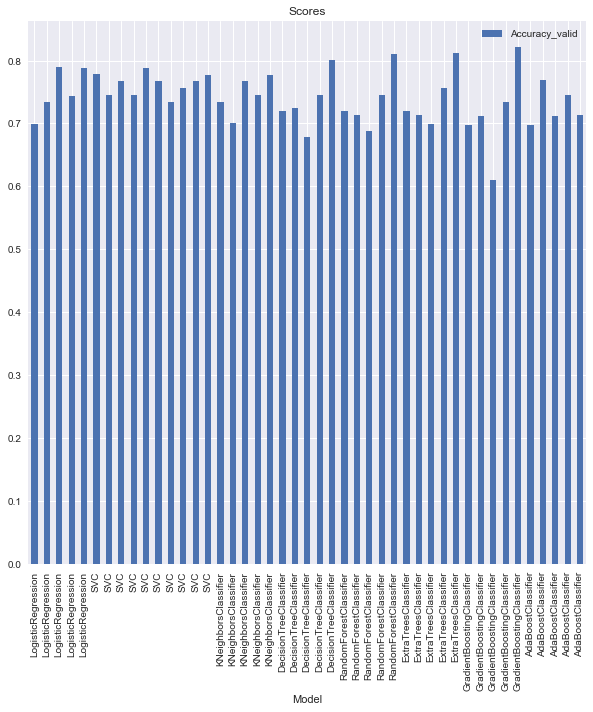

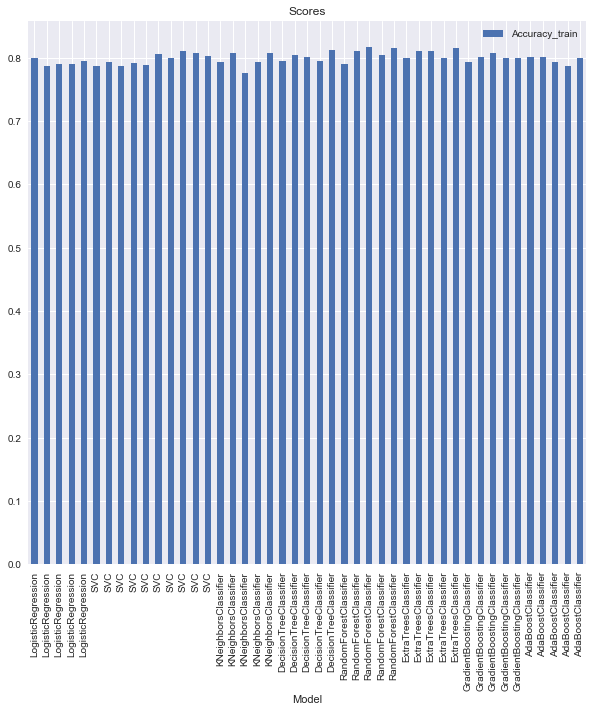

In [61]:
from sklearn.metrics import accuracy_score

scores = pd.DataFrame(columns= ['Model','Accuracy_valid', 'Accuracy_train'])

for i, model in enumerate(models):
    for j, (train_index, test_index) in enumerate(sss.split(X, Y)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        Y_train, Y_test = Y.loc[train_index], Y.loc[test_index]
        
        # if I had a continuous feature that I needed to scale, I would place it here.
        sc_1 = StandardScaler().fit(X_train["FareBin"])
        X_train["FareBin"] = sc_1.transform(X_train["FareBin"])
        X_test["FareBin"] = sc_1.transform(X_test["FareBin"]) 
        
        sc_2 = StandardScaler().fit(X_train["FamilySize"])
        X_train["FamilySize"] = sc_2.transform(X_train["FamilySize"])
        X_test["FamilySize"] = sc_2.transform(X_test["FamilySize"])
        
        sc_4 = StandardScaler().fit(X_train["Pclass"])
        X_train["Pclass"] = sc_4.transform(X_train["Pclass"])
        X_test["Pclass"] = sc_4.transform(X_test["Pclass"])
        
     
        sc_6 = StandardScaler().fit(X_train["Cl*Sex"])
        X_train["Cl*Sex"] = sc_6.transform(X_train["Cl*Sex"])
        X_test["Cl*Sex"] = sc_6.transform(X_test["Cl*Sex"])
        
    
    
        model.fit(X_train, Y_train)
        Chart_1[test_index, i-1] = model.predict(X_test)
        Chart_2[ :, j-1] = model.predict(X_pred)
        Chart_3[ :, i-1] = Chart_2.mean(axis= 1)
        name = str(model).rsplit('(', 1)[0]
        accuracy_val = np.average(cross_val_score(model, X_test, Y_test, scoring= "accuracy"))
        accuracy_train = np.average(cross_val_score(model, X_train, Y_train, scoring= "accuracy"))
        scores = scores.append({'Model': name,'Accuracy_valid': accuracy_val, 'Accuracy_train': accuracy_train}, ignore_index=True)

scores.set_index("Model") 
scores.plot(x= 'Model', y = 'Accuracy_valid', kind='bar', title='Scores' )
scores.plot(x= 'Model', y = 'Accuracy_train', kind='bar', title='Scores' )

In [67]:
stacking = LogisticRegression().fit(Chart_1, Y)
Y_submit = stacking.predict(Chart_3)

In [68]:
Y_submit = Y_submit.astype(int)
submission = pd.DataFrame({ 'PassengerId': prediction_indexes,
                            'Survived': Y_submit })
submission.to_csv("submission_26Febr.csv", index=False)
